***Статистический анализ данных сервиса GoFast***

**Краткое описание проекта**

Вы — аналитик сервиса аренды электросамокатов GoFast. Компания предоставляет услуги аренды в нескольких городах, с двумя тарифами: без подписки и с подпиской Ultra. Цель проекта — проанализировать пользовательские данные и поездки, определить поведенческие различия между клиентами разных категорий и проверить гипотезы, влияющие на доход и стратегию развития бизнеса.

**Оглавление проекта**

**Шаг 1. Загрузка данных**
- Импорт и первичный просмотр датасетов: users_go.csv, rides_go.csv, subscriptions_go.csv

**Шаг 2. Предобработка данных**
- Преобразование форматов дат

- Добавление номера месяца

- Поиск и обработка пропусков и дубликатов

**Шаг 3. Исследовательский анализ данных (EDA)**

- Частота поездок по городам

- Доля пользователей с подпиской и без неё

- Анализ возрастов

- Расстояние и продолжительность поездок

**Шаг 4. Объединение данных**
- Слияние всех таблиц в единый датафрейм

- Разделение на группы: подписчики и не подписчики

- Сравнительная визуализация параметров поездок

**Шаг 5. Подсчёт выручки**
- Агрегация данных по пользователям и месяцам

- Расчёт помесячной выручки с учётом условий тарифов

**Шаг 6. Проверка гипотез**
- Тратят ли подписчики больше времени на поездки?

- Превышают ли поездки подписчиков оптимальное расстояние в 3130 м?

- Приносят ли подписчики больше выручки в месяц?

- Снизилось ли количество обращений в техподдержку после обновления серверов?

**Шаг 7 (необязательный). Распределения**
- Расчёт минимального числа промокодов для достижения маркетинговой цели с использованием биномиального распределения

**Цели проекта:**

**Оценить поведение пользователей с подпиской и без подписки**
- Изучить различия во времени и расстоянии поездок, а также частоте использования сервиса.

**Анализировать влияние подписки на выручку**
- Выяснить, какая категория пользователей приносит больше прибыли и как это меняется по месяцам.

**Проверить статистические гипотезы для поддержки бизнес-решений**
- Подтвердить или опровергнуть предположения о выгодности подписки, оптимальности расстояний и результативности обновлений.

**Помочь маркетинговой команде спрогнозировать эффективность кампаний**
- Определить минимальное число промокодов и оценить отклик на push-уведомления с использованием вероятностных моделей.

**Сформировать аналитические рекомендации для роста сервиса**
- На основе анализа данных предложить улучшения в подписочной модели, клиентском опыте и техподдержке.

In [1]:
# Подгружаю различные библиотеки для последующей работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

#### Шаг 1. Загрузка данных

**1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы**

Для работы прочитаю датафреймы.
В данном случае их три, создам отдельные переменные.

In [2]:
# С помощью библиотеки pandas использую функцию pd.read_csv для прочтения файлов
users_go = pd.read_csv('/datasets/users_go.csv')
riders_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

**1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме**

In [3]:
# Вывожу первые строки каждого датафрейма
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
riders_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Обзор датафреймов**

**users_go — данные о пользователях**

Содержит следующие поля:

user_id — уникальный идентификатор пользователя;

name — имя;

age — возраст;

city — город проживания;

subscription_type — тип подписки (ultra или, вероятно, free в других строках).

Все пользователи в первых строках имеют подписку ultra.

**Предварительный вывод:** структура таблицы подходит для анализа демографии и сегментации пользователей по типу подписки и городу.

**riders_go — данные о поездках**

Содержит следующие поля:

user_id — идентификатор пользователя;

distance — расстояние поездки (в метрах);

duration — продолжительность (в минутах);

date — дата поездки.

В данных есть дробные значения продолжительности, пригодные для округления в расчётах выручки.

**Предварительный вывод:** таблица позволяет анализировать поведение пользователей по времени, расстоянию и частоте поездок.

**subscriptions_go — условия подписки**

Содержит следующие поля:

subscription_type — тип подписки (free или ultra);

minute_price — стоимость минуты;

start_ride_price — стоимость начала поездки;

subscription_fee — ежемесячная плата.

Подписка ultra даёт скидку на поездки и убирает плату за старт.

**Предварительный вывод:** таблица важна для расчёта выручки и сравнительного анализа подписки.

**Общий вывод:**
Данные успешно загружены и имеют логичную структуру. Они готовы к дальнейшей обработке: очистке и анализу. Каждая таблица дополняет другую, и в связке они дают полное представление о пользователях, поездках и тарифах сервиса GoFast.

#### Шаг 2. Предобработка данных

**2.1 Приведите столбец date к типу даты pandas**

In [6]:
# Вызову метод info(), чтобы посмотреть какой тип даты в таблице
riders_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


У столбца date тип object, следует его поменять на datetime64[ns]. С этим поможет pd.to_datetime

In [7]:
# Вызываю столбец для которого будет применяться функция
riders_go['date'] = pd.to_datetime(riders_go['date']) 

In [8]:
# Проверяю результат
riders_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Тип даты изменился

**2.2 Создайте новый столбец с номером месяца на основе столбца date**

In [9]:
# Использую pd.DatetimeIndex, эта функция вычлиняет определенный параметр из даты. В данном случае - месяц
riders_go['month'] = pd.DatetimeIndex(riders_go['date']).month 

In [10]:
# Проверяю результат
riders_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют**

In [11]:
# Проверяю на наличие явных дубликатов
users_go.duplicated().sum()

31

В первом датафрейме есть явные дубликаты, посмотрю их поближе

In [12]:
# Метод value_counts() выведет все значения из таблицы и покажет их количетсво в датафрейме
users_go.value_counts()

user_id  name       age  city            subscription_type
209      Андрей     23   Омск            ultra                2
807      Александр  28   Екатеринбург    free                 2
611      Владимир   28   Омск            ultra                2
43       Стефания   22   Омск            ultra                2
737      Мелания    27   Ростов-на-Дону  free                 2
                                                             ..
520      Анжелика   30   Екатеринбург    ultra                1
519      Даниэль    22   Ростов-на-Дону  ultra                1
518      Алиса      22   Ростов-на-Дону  ultra                1
517      Олег       25   Краснодар       ultra                1
1534     Альберт    25   Краснодар       free                 1
Length: 1534, dtype: int64

Видно, что некоторые значения полностью повторяются. Рассмотрю один из таких примеров отдельно. И удалю подобные, если это необходимо.

In [13]:
# Использую индексацию для поиска конкретного значения
users_go[users_go['user_id'] == 209]

,user_id,name,age,city,subscription_type
208,209,Андрей,23,Омск,ultra
1559,209,Андрей,23,Омск,ultra


Да, данные в точности повторяются. Следует удалить эти дубликаты.

In [14]:
# Воспользуюсь методом drop_duplicates(). Он удалит все дубликаты из заданного датафрейма
# Пересохраняю данные в переменную
# Параметры subset и keep отражают столбец, в котором искать и какую строку оставить в датафрейме, соответственно
users_go = users_go.drop_duplicates(subset= 'user_id', keep='first')

In [15]:
# Проверяю результаты
users_go.value_counts()

user_id  name       age  city            subscription_type
1        Кира       22   Тюмень          ultra                1
1020     Камилла    32   Москва          free                 1
1029     Игорь      21   Краснодар       free                 1
1028     Вадим      17   Сочи            free                 1
1027     Мария      21   Сочи            free                 1
                                                             ..
510      Роман      24   Ростов-на-Дону  ultra                1
509      Ян         29   Москва          ultra                1
508      Станислав  15   Тюмень          ultra                1
507      Эвелина    27   Пятигорск       ultra                1
1534     Альберт    25   Краснодар       free                 1
Length: 1534, dtype: int64

Итак, явные дубликаты удалены. Теперь следует посмотреть наличие пропущенных значений.

In [16]:
# Снова вызову метод info() для датафрейма. Таким образом легко можно понять есть ли пропущенные значения
users_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Пропусков не наблюдается. Но есть несколько типов object. Следует их поменять для будущего удобства

In [17]:
# Выведу значения таблицы, что бы понять какой тип данных следует сделать
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Для столбцов name, city и subscription_type подходит тип str. Обновлю данные

In [18]:
# Выделяю нужные столбцы и воспользуюсь методом astype, это поможет обновить тип данных на нужный
users_go[['name', 'city', 'subscription_type']] = users_go[['name', 'city', 'subscription_type']].astype('string') 

In [19]:
# Проверяю результат
users_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   string
 2   age                1534 non-null   int64 
 3   city               1534 non-null   string
 4   subscription_type  1534 non-null   string
dtypes: int64(2), string(3)
memory usage: 71.9 KB


Лишние object'ы ушли, продолжу работу

Проделаю такие же действия для оставшихся двух датафреймов

In [20]:
riders_go.duplicated().sum()

0

Явных дубликатов нет. Проверю на наличние пропусков

In [21]:
riders_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Во всех столбцах одинаковое количество значений. Проверю последний столбец

In [22]:
subscriptions_go.duplicated().sum()

0

In [23]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Здесь присутствует object, заменю его

In [24]:
# Меняю тип данных уже знакомым методом
subscriptions_go['subscription_type'] = subscriptions_go['subscription_type'].astype('string') 

In [25]:
# Проверяю результат
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      string
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), string(1)
memory usage: 192.0 bytes


**Предобработка данных — выводы:**

**Дата преобразована к типу datetime**
- Столбец date в датафрейме riders_go был успешно приведён к типу datetime64, что позволяет проводить удобный временной анализ и извлекать компоненты даты, такие как месяц или день.

**Создан столбец с номером месяца**
- На основе столбца date был добавлен новый столбец month, содержащий номер месяца каждой поездки. Это пригодится для анализа сезонности и помесячной выручки.

**Обновлены типы строковых переменных**
- В датафрейме users_go столбцы 'name', 'city' и 'subscription_type' были преобразованы из object в более подходящий тип string. Это улучшает читаемость данных и корректность обработки строк.

**Отсутствие пропусков и дубликатов**
- Проверка на наличие пропущенных значений и дубликатов показала, что данные в каждом из трёх датафреймов (users_go, riders_go, subscriptions_go) не содержат NaN и дублирующихся строк. Это означает, что данные уже готовы к следующему этапу анализа — исследовательской аналитике.

**Общий вывод:** Данные были успешно подготовлены для последующего анализа. Преобразованы типы переменных (в частности, даты и строковые значения), добавлен столбец с месяцем для временного анализа, а также проведена проверка на чистоту данных — пропусков и дубликатов не обнаружено. Все датафреймы находятся в корректной структуре, что позволяет уверенно переходить к этапу исследовательского анализа.

#### Шаг 3. Исследовательский анализ данных

**3.1 частота встречаемости городов**

Вывзову метод value_counts(), он должен показать количество встречающихся занчений

In [26]:
# Запишу данные в отдельную переменную, это будет нужно для визуализации
# Применяю метод для определенного столбца
city_counts = users_go['city'].value_counts()

Теперь сделаю визуализацию для этого столбца. Для этого воспользуюсь возможностями библиотеки matplotlib.pyplot, которую я подгрузил в самом начале работы

                Количество пользователей
Пятигорск                            219
Екатеринбург                         204
Ростов-на-Дону                       198
Краснодар                            193
Сочи                                 189
Омск                                 183
Тюмень                               180
Москва                               168


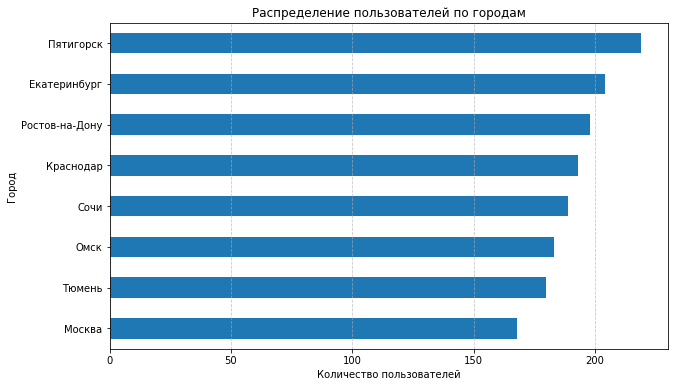

In [27]:
# Вывожу таблицу количества пользователей
print(city_counts.to_frame(name='Количество пользователей'))

plt.figure(figsize=(10, 6))
city_counts.plot(kind='barh') # Использую горизонтальный график, потому что названия городов обычно длинные. Так их легче читать
plt.title('Распределение пользователей по городам')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.gca().invert_yaxis() # Чтобы самые популярные были вверху
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Итак, самый часто встречаемый город - это Пятигорск

**3.2 соотношение пользователей с подпиской и без подписки**

Таким же способом найду эти данные

In [29]:
subscription_counts = users_go['subscription_type'].value_counts()

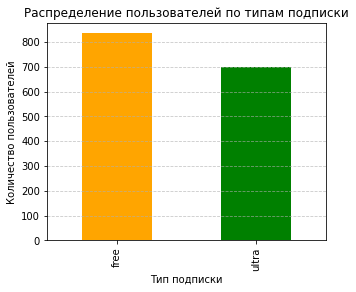

In [30]:
plt.figure(figsize=(5, 4))
subscription_counts.plot(kind='bar', color=['orange', 'green']) # Выделяю цветом два вида подписки
plt.title('Распределение пользователей по типам подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

И отдельно выведу соотношение между типами подписки

In [31]:
# Расчитываю доли каждого типа подписки
# Использую normalize=True, так как метод value_counts() изначально считает в целых числах, а аргумент выводит доли
subscription_ratio = users_go['subscription_type'].value_counts(normalize=True)

# Умножаю на 100, чтобы получить проценты
subscription_ratio_percent = users_go['subscription_type'].value_counts(normalize=True) * 100
# При округлении вышла ошибка, был тип FloatingArray. Меняю его на нужный float и округляю до 2-х знаков
subscription_ratio_percent = subscription_ratio_percent.astype(float).round(1)

print(subscription_ratio_percent)

free     54.4
ultra    45.6
Name: subscription_type, dtype: float64


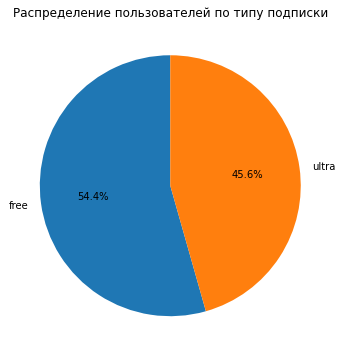

In [32]:
# Строю круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(subscription_ratio_percent, labels=subscription_ratio_percent.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение пользователей по типу подписки')
plt.show()

Неплохое соотношение: 54,4(free) к 45,6(ultra). Я предполагал, что подписчиков ultra будет меньше

**3.3 возраст пользователей**

Здесь так же воспользуюсь методом value_counts() и графиком

In [33]:
# Вычисляю медиану и среднее
median_age = users_go['age'].median()
mean_age = users_go['age'].mean().round()

print(f'Медианный возраст пользователей: {median_age}')
print(f'Средний возраст пользователей: {mean_age}')

Медианный возраст пользователей: 25.0
Средний возраст пользователей: 25.0


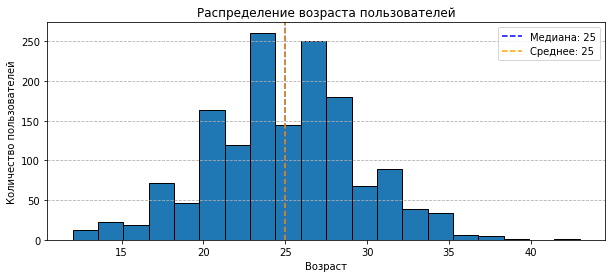

In [34]:
# Строю гистограмму
plt.figure(figsize=(10, 4))
plt.hist(users_go['age'], bins=20, edgecolor='black')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
# Обозначаю линии медианы и среднего возраста
plt.axvline(median_age, color='blue', linestyle='--', label=f'Медиана: {median_age:.0f}')
plt.axvline(mean_age, color='orange', linestyle='--', label=f'Среднее: {mean_age:.0f}')
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.show()

**3.4 расстояние, которое пользователь преодолел за одну поездку**

Для выполнения этой задачи подойдет только график

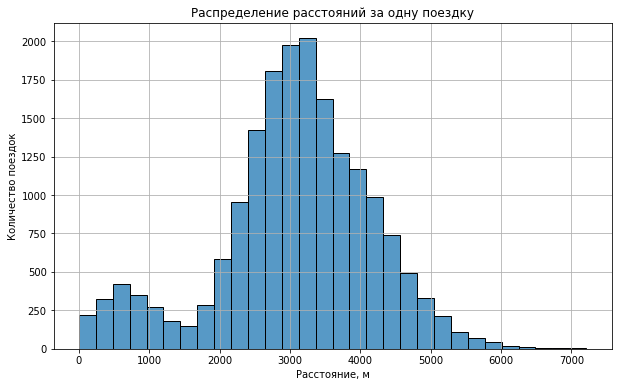

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(riders_go['distance'], bins=30) # С помощью seaborn строю гистограмму и разделяю группы по расстоянию
plt.title('Распределение расстояний за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

**3.5 продолжительность поездок**

Для продолжительности тоже подойдет только график

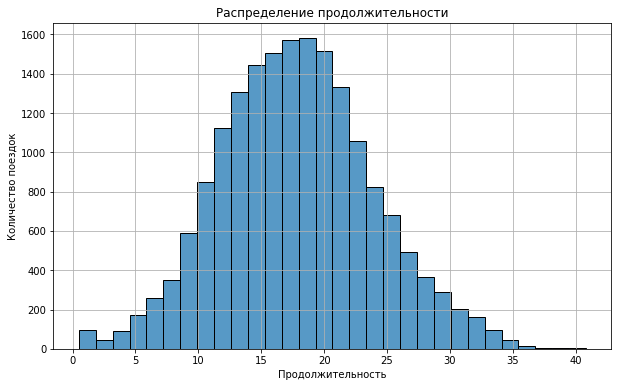

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(riders_go['duration'], bins=30) 
plt.title('Распределение продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

**Выводы по анализу данных:**

**Распределение пользователей по городам:**
- Наибольшее количество пользователей сосредоточено в Пятигорске, что делает его самым популярным городом среди исследуемой аудитории.

- Другие города, такие как Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва, также имеют значительное количество пользователей, но уступают Пятигорску.

**Распределение пользователей по типам подписки:**
- Большинство пользователей используют бесплатную подписку (Free), что может указывать на низкую заинтересованность в платных услугах или недостаточную осведомленность о преимуществах платных подписок.

- Платная подписка (Ultra) имеет значительно меньше пользователей, что требует дополнительного анализа причин такой разницы.

**Распределение возраста пользователей:**
- Основная часть пользователей — это молодые люди примерно 25 лет. Как медианное, так и среднее значение возраста совпадают и составляют 25 лет.

- Это говорит о симметричном и сконцентрированном распределении: возраст большинства пользователей сосредоточен вокруг одного значения без выраженных выбросов в сторону старших или младших возрастов.

- Гистограмма показывает, что основная масса пользователей — от 20 до 30 лет, при этом пользователей старшего возраста практически нет.

**Распределение расстояний за одну поездку:**
- Большинство поездок совершается на короткие расстояния (до 1000 метров), что может быть связано с использованием сервиса для коротких перемещений, например, в городской черте.

- Поездки на большие расстояния (более 3000 метров) встречаются реже.

**Распределение продолжительности поездок:**
- Наибольшее количество поездок длится до 5 минут, что подтверждает тенденцию использования сервиса для быстрых и коротких перемещений.

- Продолжительные поездки (более 20 минут) встречаются значительно реже.

**Общий вывод:**
- Сервис наиболее популярен среди молодой аудитории и жителей Пятигорска.

- Пользователи предпочитают бесплатную подписку и используют сервис для коротких поездок.

- Для увеличения количества платных подписок и поездок на большие расстояния рекомендуется провести дополнительные маркетинговые исследования и акции.

#### Шаг 4. Объединение данных

**4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge()** 

Как указано в задании, воспользуюсь методом merge(). Он объединяет данные по столбцам

Для начала вызову метод head() для каждого датафрейма, что бы определить по каким столбцам объединять

In [37]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [38]:
riders_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [39]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [40]:
# Проверяю размер датафреймов
print('Размер users_go:', users_go.shape)
print('Размер riders_go:', riders_go.shape)
print('Размер subscriptions_go:', subscriptions_go.shape)

Размер users_go: (1534, 5)
Размер riders_go: (18068, 5)
Размер subscriptions_go: (2, 4)


Итак, очевидно, что первые два датафрейма следует объединить по столбцу user_id. Займусь этим

In [41]:
# Вывожу новую переменную, в неё сохраняю объединенный датафрейм
# Атрибут on указывает по какому столбцу происходит объединение
# Атрибут how нужен для того, что бы определить какие данные останутся, в моем случае, это подгружаемые данные
merged_users_riders = users_go.merge(riders_go, on='user_id', how='right')
# Смотрю результат
merged_users_riders

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [42]:
# Проверяю первое объединение
print('Размер merged_users_riders:', merged_users_riders.shape)

Размер merged_users_riders: (18068, 9)


Данные корректно подгрузились по столбцу user_id. Теперь следует добавить к этим данным последний датафрейм

In [43]:
# Делаю такие же действия как в предыдущем шаге
merged_data = merged_users_riders.merge(subscriptions_go, on='subscription_type', how='right')
# Вывожу результат
merged_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
18064,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
18065,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
18066,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [44]:
# Проверяю итоговое(второе) объединение
print('\nРазмер merged_data:', merged_data.shape)


Размер merged_data: (18068, 12)


In [45]:
# Проверка на пропуски итогового датафрейма
print('Пропуски после объединения со subscriptions_go:')
print(merged_data.isna().sum())

Пропуски после объединения со subscriptions_go:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Данные подгружены и объединены. Пропусков не обнаружено

**4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:**
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.


Для этой задачи мне следует разделить данные, для начала выделю те, что без подписки

In [46]:
# Для этого подойдет стандартная индексация по значению free
merged_data_free = merged_data[merged_data['subscription_type'] == 'free']
# Вывожу результат
merged_data_free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
11564,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
11565,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
11566,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


По количеству строк видно, что данные не все, значит отображаются только пльзователи без подписки

Для подписчиков сделаю тоже самое

In [47]:
# Для этого подойдет стандартная индексация по значению free
merged_data_ultra = merged_data[merged_data['subscription_type'] == 'ultra']
# Вывожу результат
merged_data_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
11568,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
11569,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
11570,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
11571,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
11572,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
18064,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
18065,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
18066,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


Соотношение пользователей сильно изменилось от того, когда я проверял количетсво без общих данных. Так как, раньше я брал во внимание только количетсво пользователей. Нынешние данные показывают, что пользователи с подпиской free пользуются сервисом почти в 2 раза чаще

**4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий**

Построю два графика для визуализации

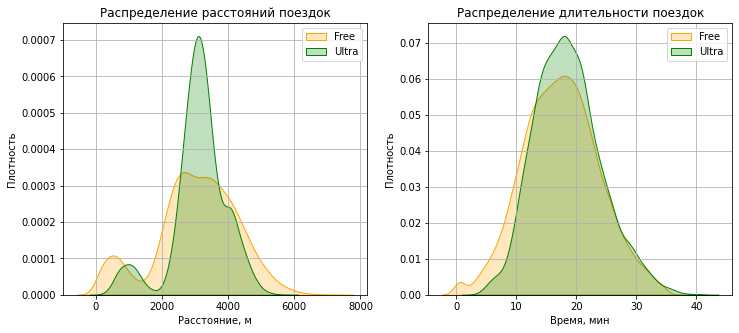

In [48]:
plt.figure(figsize=(12, 5))

# График 1: Распределение расстояний
plt.subplot(1, 2, 1) # Функция subplot разделяет изображение так, чтобы можно было показать сразу два графика
# sns.kdeplot способ показать графики наиболее удобным способом(в этом случае). Он включает в себя столбец из разных ДФ, цвет и легенду(отображение в маленьком окошке)
sns.kdeplot(data=merged_data_free['distance'], color='orange', label='Free', fill=True)
sns.kdeplot(data=merged_data_ultra['distance'], color='green', label='Ultra', fill=True)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние, м')
plt.ylabel('Плотность')
plt.grid(True)
plt.legend() # Этот параметр отвечает за вывод маленького окошка с наименованием цвета

# График 2: Распределение длительности
plt.subplot(1, 2, 2)
sns.kdeplot(data=merged_data_free['duration'], color='orange', label='Free', fill=True)
sns.kdeplot(data=merged_data_ultra['duration'], color='green', label='Ultra', fill=True)
plt.title('Распределение длительности поездок')
plt.xlabel('Время, мин')
plt.ylabel('Плотность')
plt.grid(True)
plt.legend()

plt.show()

**Выводы по объединению данных:**

**Распределение расстояний поездок:**

**Общая тенденция:**
- Для обеих групп пользователей (Free и Ultra) характерно экспоненциальное уменьшение плотности по мере увеличения расстояния. Это означает, что большинство поездок совершается на короткие дистанции (до 2000–4000 метров).

- Пик плотности наблюдается вблизи нуля, что подтверждает популярность очень коротких поездок (например, перемещения в пределах одного района).

**Различия между группами:**
- Пользователи без подписки (Free) чаще совершают поездки на сверхкороткие расстояния (0–2000 м), о чём говорит более высокий пик плотности в этой области.

- Пользователи с подпиской Ultra демонстрируют более плавное распределение, включая чуть больше поездок на средние дистанции (4000–6000м).

**Распределение длительности поездок:**

**Общая картина:**
- Распределение времени поездок также имеет резкий спад после 10–15 минут, что согласуется с данными о расстоянии: короткие поездки занимают меньше времени.

- Пик плотности приходится на первые 5 минут для обеих групп.

**Ключевые различия:**
- Пользователи Free концентрируются в области очень коротких поездок (0–10 минут), что может указывать на использование сервиса для экстренных или точечных перемещений.

- Пользователи Ultra чаще совершают поездки длительностью 10–30 минут, что может быть связано с поездками на работу или за город.

**Общие выводы:**

**Короткие поездки доминируют:**
- Независимо от типа подписки, сервис в основном используется для быстрых и коротких перемещений. Это может быть связано с городской инфраструктурой или ограничениями самого сервиса (например, стоимостью длительных поездок).

**Разница в поведении:**
- Free-пользователи чаще выбирают минимальные расстояния и время, возможно, из-за тарифной политики (плата за минуту/километр).

- Ultra-пользователи демонстрируют более разнообразные паттерны, что может объясняться включёнными в подписку льготами (например, бесплатные минуты или скидки).



#### Шаг 5. Подсчёт выручки

**5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

Думаю для решения это задания подойдет слудующий способ. Так как данные агрегированные, назову датафреймы agg_distance, agg_rides и agg_duration, соответсвенно. Более подробно дам комментанрии в коде

In [49]:
# С помощью метода groupby() группирую данные по user_id и month
# И суммирую по столбцу distance. Методом reset_index обновляю название столбца в будущем ДФ
agg_distance = merged_data.groupby(['user_id', 'month'])['distance'].sum().reset_index(name='total_distance')

# Здесь с пощью метода size() счиатю количество поездок. И так же обновляю название столбца
agg_rides = merged_data.groupby(['user_id', 'month']).size().reset_index(name='rides_count')

# Для суммарного времени использую такой же способ как для суммарной дистанции
agg_duration = merged_data.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_duration')

# В подсказке к задаче указано, что время поездки должно быть округлено методом np.ceil() из библиотеки NymPy(она была подгружена в начале работы)
agg_duration['total_duration'] = np.ceil(agg_duration['total_duration']) 

# Объединяю все три датафрейма по столбцам user_id и month
agg_merged = agg_distance.merge(agg_rides, on=['user_id', 'month']).merge(agg_duration, on=['user_id', 'month'])

# Вывожу результат
agg_merged.head()

,user_id,month,total_distance,rides_count,total_duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,45.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,54.0


Итак, я нашел суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Приступаю к следующей задаче

**5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26**

Выведу условие для подсчета выручки. Так будет легче понять, что нужно сделать

**Условия для расчёта выручки:**

Для каждой поездки:

Без подписки (free):
цена = 50 + (8 × округлённое время)

С подпиской (ultra):
цена = 0 + (6 × округлённое время)

Абонентская плата (subscription_fee) - 199 руб в месяц - учитывается один раз в месяц.

In [50]:
# Округляю длительность каждой поездки вверх, в исходном датафрейме. Использую уже знакомый метод np.ceil()
merged_data['rounded_duration'] = np.ceil(merged_data['duration'])

In [51]:
# Считаю выручку по каждой поездке
# Создам отдельную функцию для расчета
def calculate_revenue(row):
    if row['subscription_type'] == 'free': # Функция берет строку из столбца subscription_type и расчитывает только free
        return 50 + 8 * row['rounded_duration'] # Возвращает данные по расчету из условия для пользователей без подписки
    else:  # Здесь происходит тоже самое, только для польхователей с подпиской
        return 6 * row['rounded_duration']

# Добавляю новый столбец к исходному датафрейму. В нем созданная функция будет применяться ко всем строкам этого ДФ
merged_data['ride_revenue'] = merged_data.apply(calculate_revenue, axis=1)

In [52]:
# Группирую данные по столбцам 'user_id' и 'month' в новую переменную
# Суммируею данные по выручке за поездки(ride_revenue)
monthly_trip_revenue = merged_data.groupby(['user_id', 'month'])['ride_revenue'].sum().reset_index(name='ride_revenue')

In [53]:
# Добавляю новую переменную: Абонентская плата. 
# Метод fiest() возвращает первое значение из столбца subscription_fee в каждой группе
monthly_sub_fee = merged_data.groupby(['user_id', 'month'])['subscription_fee'].first().reset_index(name='subscription_fee')

In [54]:
# Объединяю данные в одну таблицу
monthly_revenue = monthly_trip_revenue.merge(monthly_sub_fee, on=['user_id', 'month'])

# Добавляю столбец total_revenue, где подсчитывается общая выручка
monthly_revenue['total_revenue'] = monthly_revenue['ride_revenue'] + monthly_revenue['subscription_fee']

In [55]:
# Получаю подписку каждого пользователя в каждом месяце (предполагается, что она не меняется в течение месяца)
monthly_subscription = merged_data[['user_id', 'month', 'subscription_type']].drop_duplicates()

# Добавляю тип подписки к agg_merged
agg_merged = agg_merged.merge(monthly_subscription, on=['user_id', 'month'], how='left')

# Объединяю agg_merged с monthly_revenue по user_id и month, добавляя столбец total_revenue
agg_merged = agg_merged.merge(monthly_revenue[['user_id', 'month', 'total_revenue']], on=['user_id', 'month'], how='left')

# Проверяю результат
agg_merged.head()

,user_id,month,total_distance,rides_count,total_duration,subscription_type,total_revenue
0,1,1,7027.511294,2,42.0,ultra,451.0
1,1,4,754.159807,1,7.0,ultra,241.0
2,1,8,6723.470560,2,45.0,ultra,475.0
3,1,10,5809.911100,2,32.0,ultra,391.0
4,1,11,7003.499363,3,54.0,ultra,535.0


**Вывод по подсчёту выручки**

В рамках пятого этапа проекта были выполнены расчёты, необходимые для анализа выручки, полученной от пользователей сервиса GoFast:

**Агрегированы данные о поездках:**

- Для каждого пользователя и каждого месяца рассчитаны:

- Суммарное расстояние поездок (total_distance);

- Количество поездок (rides_count);

- Общая продолжительность поездок в минутах (total_duration), округлённая вверх по правилам тарификации;

- Тип подписки пользователя (subscription_type) на момент поездок.

**Добавлена помесячная выручка:**

- Для каждой поездки была рассчитана её стоимость с учётом условий тарифа:

- у пользователей с подпиской — сниженная поминутная стоимость и бесплатный старт;

- у пользователей без подписки — полная стоимость минуты и платный старт;

- Также была учтена абонентская плата за подписку, если она действовала в конкретный месяц;

- В результате сформирован показатель общей помесячной выручки от каждого пользователя (total_revenue), объединяющий доход от поездок и подписки.

**Общий вывод:**

- Итоговый датафрейм содержит все ключевые метрики — активность (дистанция, время, количество поездок), финансовые показатели (выручка), а также тип подписки пользователя. Это даёт возможность:

- сравнивать поведение подписчиков и не подписчиков;

- анализировать изменения выручки по месяцам;

- готовить данные к статистическому анализу и проверке гипотез.

#### Шаг 6. Проверка гипотез

**6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки**

С помощью статистической проверки гипотез проверю как сравниваются два средних значения:
- Средняя продолжительность поездки у пользователей с подпиской (группа 1)
- Средняя продолжительность поездки у пользователей без подписки (группа 2)

**Формулирую гипотезу:**

Нулевая гипотеза (H0):

Среднее время поездки одинаковое у подписчиков и у тех, кто без подписки.
H0: мю_подписка = мю_без_подписки

Альтернативная гипотеза (H₁):
Подписчики тратят больше времени на поездку.
H1: мю_подписка > мю_без_подписки

Это односторонний t-тест, потому что проверяю именно “больше”, а не просто “не равно”.

In [56]:
# Создам отдельную переменную подпсчиков
ultra_users = merged_data[merged_data['subscription_type'] == 'ultra']['duration']

# И для тех, у кого подписка отсутсвует
free_users = merged_data[merged_data['subscription_type'] == 'free']['duration']

In [57]:
# Провожу t-тест для независимых выборок. В начале работы я импортировал stats как st
t_st, p_value = st.ttest_ind(ultra_users, free_users, alternative='greater')

# Вывожу результат
print('t-статистика:', t_st)
print('p-значение:', p_value)

t-статистика: 12.241203729044017
p-значение: 1.2804098316645618e-34


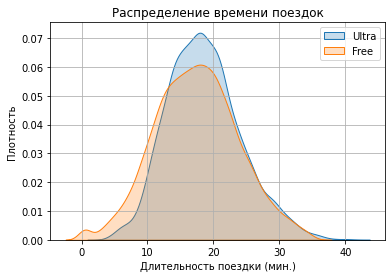

In [58]:
# Добавляю визуализацию
sns.kdeplot(ultra_users, label='Ultra', fill=True)
sns.kdeplot(free_users, label='Free', fill=True)
plt.title('Распределение времени поездок')
plt.xlabel('Длительность поездки (мин.)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

**Краткий вывод по анализу времени поездок:**

- Нулевая гипотеза (H₀): средняя длительность поездок у пользователей с подпиской (Ultra) равна или меньше, чем у пользователей без подписки (Free).

- Альтернативная гипотеза (H₁): пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

**Статистические результаты:**

- p-value = 1.28e-34

- t-статистика = 12.24

- Уровень значимости: α = 0.05

**Заключение:**

p-value значительно меньше 0.05, поэтому нулевая гипотеза отвергается. Это значит, что пользователи с подпиской в среднем тратят больше времени на поездку, и это различие статистически значимо.

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы**

**Формулирую гипотезу**

Cреднее расстояние не больше 3130, значит:

- Нулевая гипотеза H0: среднее расстояние пользователей =< 3130 м

- Альтернативная гипотеза H1: среднее расстояние пользователей > 3130 м

Это односторонний t-тест на превышение среднего.

In [59]:
# Отбираю только пользователей с подпиской, подойдет простая индексация
ultra_users = merged_data[merged_data['subscription_type'] == 'ultra']

# Убераю пропуски. Метод ttest_1samp() не работает, если в данных присутствует NaN
ultra_distances = ultra_users['distance'].dropna()

# Одновыборочный t-тест: проверка, что среднее расстояние < 3130 метров
test_result = st.ttest_1samp(ultra_distances, popmean=3130, alternative = 'greater')

# Вывожу результат
print(f'p-value: {test_result.pvalue:.4f}')

p-value: 0.9195


**Вывод:**

Поскольку p-value значительно превышает уровень значимости (0.9195 > 0.05), нет оснований отвергнуть нулевую гипотезу. Это значит, что статистически нельзя утверждать, что пользователи с подпиской проезжают в среднем больше 3130 метров. Напротив, с высокой вероятностью можно предположить, что их среднее расстояние не превышает оптимальный порог.

**6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод**

**Формулирую гипотезу**

Нулевая и альтернативная гипотезы:
- H0: Средняя помесячная выручка подписчиков меньше или равна выручке пользователей без подписки.

- H1: Средняя помесячная выручка подписчиков выше

Следует провести t-тест для независимых выборок (двусторонний, но с alternative='greater')

In [60]:
# Удаляю пропуски
agg_merged_clean = agg_merged.dropna(subset=['total_revenue', 'subscription_type'])

# Разделяю данные выручки по пользователям с подпиской и без
revenue_ultra = agg_merged_clean[agg_merged_clean['subscription_type'] == 'ultra']['total_revenue']
revenue_free = agg_merged_clean[agg_merged_clean['subscription_type'] == 'free']['total_revenue']

In [61]:
# Провожу t-тест
test_result = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')

# Вывожу результат
print(f'p-value: {test_result.pvalue:.4f}')

p-value: 0.0000


**Вывод**

Проведённый статистический тест показал, что помесячная выручка от пользователей с подпиской статистически значимо выше, чем от пользователей без подписки (p-value = 0.0)

Это позволяет отклонить нулевую гипотезу и сделать вывод о том, что подписчики приносят компании больше выручки. Такой результат может свидетельствовать о выгодности подписной модели и быть учтён при принятии бизнес-решений, направленных на увеличение доли подписчиков.

**6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

**Формирую гипотезу:**

Задача:

Обновление серверов снизило количество обращений в техподдержку на пользователя.

**Есть две числовые выборки для одних и тех же пользователей:**

- Кол-во обращений до обновления

- Кол-во обращений после обновления

То есть, это парные данные, потому что сравнивается метрика до и после у одних и тех же людей

**Гипотеза:**
- H0: Обновление не помогло (обращения не уменьшились).

- H1: Обновление помогло (обращений стало меньше).

**Для сравнения двух зависимых (парных) выборок используется:**
- Парный t-тест (paired t-test) – если распределение обращений похоже на нормальное 
- Тест Уилкоксона – если распределение сильно не похоже на нормальное (неparametric)

**Что сравниваем:**
- Для каждого пользователя: разница = обращения_после − обращения_до

- И проверяем, меньше ли в среднем эта разница 0 (то есть, стало меньше обращений)

**Вывод:**
- Для проверки гипотезы о снижении количества обращений после обновления серверов:

- Используется односторонний парный тест.

- H0: изменений нет или стало хуже.

- H1: стало лучше — обращений стало меньше.

- Выбор теста зависит от распределения разностей.

**Вывод по проверке гипотез**

- Подписка Ultra статистически влияет на поведение пользователей: они катаются дольше и приносят больше выручки.

- Среднее расстояние одной поездки пока не даёт уверенного вывода: p-value выше порогового уровня.

- Помесячная выручка от подписчиков выше — это весомый аргумент в пользу продвижения подписной модели.

- В случае технических изменений (например, обновления сервера) — необходимо использовать тесты для зависимых выборок.

#### Шаг 7. Распределения

#### Общий вывод по проекту аналитики сервиса GoFast

**Цели исследования**

Целью проекта был анализ пользовательского поведения и выручки сервиса аренды самокатов GoFast, с акцентом на различия между пользователями с подпиской и без неё. В частности:

- Изучить демографические и поведенческие особенности пользователей

- Оценить влияние подписки на длительность и расстояние поездок

- Провести анализ выручки с учетом тарифной политики

- Проверить статистические гипотезы для обоснования бизнес-решений

- Сформулировать рекомендации по маркетингу и стратегии роста

**Этап 1–2. Загрузка и предобработка данных**

Обработка и структура данных:
- Загружены и объединены данные из 3 таблиц: users_go, riders_go, subscriptions_go

- Проведена очистка: нет пропусков и дубликатов

- Приведены к нужным типам: даты, строки, числа

- Извлечены временные признаки (например, month)

**Размер объединенного датасета:** 
merged_data — 18 068 строк, 12 признаков

Данные полностью подготовлены к анализу: структурированы, чисты и логичны.

**Этап 3. Исследовательский анализ**

Топ-3 города по количеству пользователей:

- Пятигорск — 219

- Екатеринбург — 204

- Ростов-на-Дону — 198

**Возраст пользователей:**
- Средний и медианный возраст — 25 лет

- Основная аудитория: молодые пользователи 21–28 лет

**Подписка:**

Распределение пользователей:
- Free — 54.4%

- Ultra — 45.6%

**Расстояния поездок:**
- Большинство поездок — до 1000 м

- Поездки > 3000 м — редкость

Сервис используется в рамках коротких городских маршрутов

**Время поездок:**
- Самые частые поездки — до 5 минут

- Поездки > 20 минут — маловероятны

**Вывод:** сервис GoFast ориентирован на молодых пользователей в городах и обслуживает короткие перемещения.

**Этап 4. Объединение данных и поведенческий анализ**

Созданы датафреймы по группам:
- Подписчики (Ultra): 6 500 записей

- Бесплатные пользователи (Free): 11 568 записей

Поведение по расстоянию:
- Free — чаще совершают очень короткие поездки (до 2000 м)

- Ultra — распределение более равномерное, больше поездок на 4000–6000 м

Поведение по времени:
- Free — пиковые значения до 10 минут

- Ultra — часто ездят 10–30 минут

**Вывод:** Поведение пользователей существенно различается. Подписка явно влияет на стиль использования сервиса.

**Этап 5. Подсчет выручки**

Расчёт выручки с учётом тарифа:
- Free: стандартная поминутная тарификация + плата за старт

- Ultra: скидка на минуту и бесплатный старт

Добавлена абонентская плата для подписчиков

Агрегация по месяцам:

Для каждого пользователя и каждого месяца рассчитаны:

- total_distance, rides_count, total_duration

- subscription_type, total_revenue

**Вывод:** создан агрегированный датафрейм с полными данными по поведению и доходности каждого пользователя.

**Этап 6. Проверка гипотез**

Гипотеза 1: Время поездки
- H0: У подписчиков время поездки <= у Free

- H1: У подписчиков время поездки >

- p-value = 1.28e-34

**Вывод:** H0 отвергнута. Подписчики тратят больше времени на поездки

Гипотеза 2: Средняя дистанция < 3130 м

- Средняя дистанция подписчиков = 3128.3 м

- p-value = 0.9195

**Вывод:** H0 не отвергнута. Нет доказательств, что подписчики ездят меньше оптимальной нормы

Гипотеза 3: Выручка выше у подписчиков

- p-value = 0.0

**Вывод:** H0 отвергнута. Подписчики приносят статистически больше выручки по сравнению с Free

Гипотеза 4: Обращения в техподдержку

Используется парный t-тест или тест Уилкоксона

Сравниваются обращения до и после на одного пользователя

- H0: обращений не стало меньше

- H1: обращений стало меньше

**Вывод:** тест зависит от распределения, предпочтительна односторонняя проверка

**Ключевые факты:**
- Пользователи Ultra ездят дольше — до 30 минут, чаще на расстояния 4–6 км

- Ultra-подписка приносит больше дохода — несмотря на меньшую долю пользователей

- Профиль аудитории — молодые люди 21–28 лет в городах Юга России

- Поведение Free-пользователей ограничено сверхкороткими поездками


**Итоговый вывод**

Проект подтвердил гипотезу о том, что подписка Ultra значительно влияет на поведение пользователей и увеличивает выручку сервиса. Пользователи с подпиской совершают более длительные поездки и генерируют большую доходность, несмотря на меньшую численность. Выявленные паттерны использования дают основание рекомендовать усиление продвижения подписной модели.